# First tutorial for mapping data with Tangram
- The notebook introduces to mapping single cell data on spatial data by using Tangram.
- The notebook uses data from mouse brain cortex, although different than those adopted in the manuscript (which need to wait May 2020 before being released).
- Written on Dec 30th 2020 by Tommaso Biancalani <tbiancal@broadinstitute.org>

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add path of Tangram repository for importing it
sys.path.append("/home/tbiancal/git/Tangram") 
import tangram as tg

***
#### Download the data
- We will map two different snRNA-seq datasets, both collected from adult mouse cortex: 
    - [10Xv3 MOp](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_P_allen.h5ad.gz).
    - [Smart-Seq2 VISp](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/visp_sn_tpm_small_0430.h5ad).
- For spatial data, we will use one coronal slice of [Slide-seq2 data](
https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_cropped_DUAL.h5ad.gz) (adult mouse brain; MOp area).
- We will map them via a few hundred [marker genes](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv), found in [literature](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).
- All datasets need to be unzipped: resulting `h5ad` and `csv` files should be placed in the `data` folder.

***
#### Load spatial data
- Spatial data need to be organized as a voxel-by-gene matrix. Here, Slide-seq data contains 9852 spatial voxels, in each of which there are 24518 genes measured.

In [2]:
path = os.path.join('data', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sp

AnnData object with n_obs × n_vars = 9852 × 24518
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

- The voxel coordinates are saved in the fields `obs.x` and `obs.y` which we can use to visualize the spatial ROI. Each "dot" is the center of a 10um voxel.

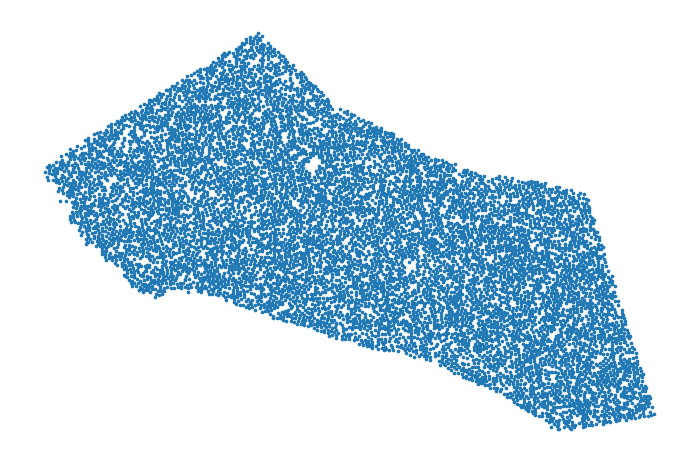

In [3]:
xs = ad_sp.obs.x.values
ys = ad_sp.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);

***
#### Single cell data

- By single cell data, we generally mean either scRNAseq or snRNAseq.
- We start by mapping the MOp 10Xv3 dataset, which contains single nuclei collected from a posterior region of the primary motor cortex.
- They are approximately 53k profiled cells with 28k genes.

In [4]:
path = os.path.join('data','mop_P_allen.h5ad')
ad_sc = sc.read_h5ad(path)
ad_sc

AnnData object with n_obs × n_vars = 52923 × 27742
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

In [5]:
df_obs  = ad_sc.obs.sample(frac=.5)
ad_sc = ad_sc[df_obs.index, :].copy()

- Usually, we work with data in raw count form, especially if the spatial data are in raw count form as well.
- If the data are in integer format, that probably means they are in raw count.

In [6]:
np.unique(ad_sc.X.toarray()[0, :])

array([0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00,
       6.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01,
       1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01,
       1.800e+01, 1.900e+01, 2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01,
       2.400e+01, 2.500e+01, 2.600e+01, 2.700e+01, 2.800e+01, 3.000e+01,
       3.100e+01, 3.200e+01, 3.300e+01, 3.500e+01, 3.600e+01, 3.700e+01,
       3.800e+01, 4.000e+01, 4.100e+01, 4.200e+01, 4.400e+01, 4.600e+01,
       4.800e+01, 4.900e+01, 5.100e+01, 5.200e+01, 5.400e+01, 5.500e+01,
       6.300e+01, 6.500e+01, 6.900e+01, 7.000e+01, 7.700e+01, 8.800e+01,
       9.200e+01, 9.500e+01, 9.800e+01, 1.090e+02, 1.170e+02, 1.740e+02,
       2.480e+02, 1.131e+03], dtype=float32)

- Here, we only do some light pre-processing as library size correction (in scanpy, via `sc.pp.normalize`) to normalize the number of count within each cell to a fixed number.
- Sometimes, we apply more sophisticated pre-processing methods, for example for batch correction, although mapping works great with raw data.
- Ideally, the single cell and spatial datasets, should exhibit signals as similar as possible and the pre-processing pipeline should be finalized to harmonize the signals.

In [7]:
sc.pp.normalize_total(ad_sc)

- It is a good idea to have annotations in the single cell data, as they will be projected on space after we map.
- In this case, cell types are annotated in the `subclass_label` field, for which we plot cell counts.
- Note that cell type proportion should be similar in the two datasets: for example, if `Meis` is a rare cell type in the snRNA-seq then it is expected to be a rare one even in the spatial data as well.

In [8]:
ad_sc.obs.subclass_label.value_counts()

L5 IT        5653
Oligo        4334
L2/3 IT      3584
L6 CT        3117
Astro        2598
Micro-PVM    1123
Pvalb         947
L5 ET         922
L6 IT         898
Sst           640
L5/6 NP       637
Vip           418
Endo          374
L6b           343
Lamp5         317
VLMC          245
Peri          194
Sncg           86
Sst Chodl      25
Meis2           6
SMC             1
Name: subclass_label, dtype: int64

- For this mapping, we exclude cell types which are rare in the snRNAseq.
- Actually, Tangram can "reuse" the same cell multiple times because mapping is probabilistic but, for this case, we want Tangram to have "enough puzzle pieces" for each cell type.

In [9]:
rare_cts = ['Meis2', 'SMC', 'Sst Chodl']
mask = ~ad_sc.obs.subclass_label.isin(rare_cts)
ad_sc = ad_sc[mask, :]
ad_sc.obs.subclass_label.value_counts()

L5 IT        5653
Oligo        4334
L2/3 IT      3584
L6 CT        3117
Astro        2598
Micro-PVM    1123
Pvalb         947
L5 ET         922
L6 IT         898
Sst           640
L5/6 NP       637
Vip           418
Endo          374
L6b           343
Lamp5         317
VLMC          245
Peri          194
Sncg           86
Name: subclass_label, dtype: int64

***
#### Prepare to map

- Tangram learns a spatial alignment of the single cell data so that  _the gene expression of the aligned single cell data is as similar as possible to that of the spatial data_.
- In doing this, Tangram only looks at a subset genes, specified by the user, called the training genes.
- The choice of the training genes is a delicate step for mapping: they need to bear interesting signals and to be measured with high quality.
- Typically, a good start is to choose 100-1000 top marker genes, evenly stratified across cell types. Sometimes, we also use the entire transcriptome, or perform different mappings using different set of training genes to see how much the result change.
- For this case, we choose 253 marker genes of the MOp area which were curated [in a different study](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).

In [10]:
df_genes = pd.read_csv('data/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)
len(markers)

253

- We now need to prepare the datasets for mapping: the two `AnnData` structures need to be subset on the list of training genes.
- Also, the gene order needs to be the same in the datasets. This is because Tangram maps using only gene expression, so the $j$-th column in each matrix must correspond to the same gene.
- This task is performed by the helper `pp_adatas`.

In [11]:
ad_sc, ad_sp = tg.pp_adatas(ad_sc, ad_sp, genes=markers)

- You'll now notice that the two datasets now contain 252 genes, but 253 markers were provided.
- This is because the marker genes need to be shared by both dataset. If a gene is missing, `pp_adatas` will just take it out.
- Finally, the `assert` line below is a good way to ensure that the genes in the `AnnData`s are actually ordered.

In [12]:
ad_sc

View of AnnData object with n_obs × n_vars = 26430 × 252
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

In [13]:
assert ad_sc.var.index.equals(ad_sp.var.index)

- At this point, it is a good to save the structures, then restart the python kernel.
- This is because we want to free as much memory as possible so that we can map.

In [14]:
ad_sc.write_h5ad('ad_sc_readytomap.h5ad')
ad_sp.write_h5ad('ad_sp_readytomap.h5ad')

***
#### Map

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add path of Tangram repository for importing it
sys.path.append("/home/tbiancal/git/Tangram") 
import tangram as tg

In [2]:
ad_sp = sc.read_h5ad('ad_sp_readytomap.h5ad')
ad_sc = sc.read_h5ad('ad_sc_readytomap.h5ad')

- We can now train the model (_ie_ map the single cell data onto space).
- Mapping should be interrupted after the score plateaus,which can be controlled by passing the `num_epochs` parameter. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data: higher score means 
- Note that we obtained excellent mapping even if Tangram converges to a low scores (the typical case is when the spatial data are very sparse): we use the score merely to assess convergence.
- For this basic mapping, we do not use regularizers (hence the `NaN`). More sophisticated loss functions can be used using the Tangram library (refer to manuscript or dive into the code :)).

In [3]:
ad_map = tg.map_cells_to_space(
    adata_cells=ad_sc,
    adata_space=ad_sp,
)

Score: 0.102, KL reg: nan, VG reg: nan
Score: 0.792, KL reg: nan, VG reg: nan
Score: 0.809, KL reg: nan, VG reg: nan
Score: 0.812, KL reg: nan, VG reg: nan
Score: 0.814, KL reg: nan, VG reg: nan
Score: 0.815, KL reg: nan, VG reg: nan
Score: 0.816, KL reg: nan, VG reg: nan
Score: 0.817, KL reg: nan, VG reg: nan
Score: 0.817, KL reg: nan, VG reg: nan
Score: 0.818, KL reg: nan, VG reg: nan


/home/tbiancal/git/Tangram/tangram/mapping_utils.py:129: RuntimeWarning: invalid value encountered in float_scalars
  cos_sims.append((v1 @ v2) / norm_sq)


- The mapping results are stored in the returned `AnnData` structure, saved as `ad_map`, structured as following:
    - The cell-by-spot matrix `X` contains the probability of cell $i$ to be in spot $j$.
    - The `obs` dataframe contains the metadata of the single cells.
    - The `var` dataframe contains the metadata of the spatial data.
    - The `uns` dictionary contains a dataframe with various information about the training genes (saved ad `train_genes_df`).
- We can now save the mapping results for post-analysis.

In [4]:
ad_map.write_h5ad('ad_map.h5ad')

***
#### Analysis

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add path of Tangram repository for importing it
sys.path.append("/home/tbiancal/git/Tangram") 
import tangram as tg

In [2]:
ad_map = sc.read_h5ad('ad_map.h5ad')
ad_map

AnnData object with n_obs × n_vars = 26430 × 9852
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    var: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'
    uns: 'train_genes_df'

- The most common goal of mapping single cell data onto space, is to transfer cell type annotations onto space.
- This is achieved by `plot_cell_annotation`, via which we visualize spatial probability maps of the passed `obs` annotations (here, the `subclass_label` field).
- The following plots recover cortical layers of excitatory neurons and sparse patterns of glia cells. The boundaries of the cortex are neatly defined by layer 6b (cell type _L6b_) and oligodendrocytes are found concentrated into sub-cortical region, as expected.
- Yet, the _VLMC_ cell type patterns does not seem correct: VLMC are clustered in the first cortical layer, whereas here are sparse in the ROI. This usually means that either (1) we have not used good marker genes for VLMC cells in our training genes (2) the present marker genes are very sparse in the spatial data, therefore they don't bear good mapping signal.

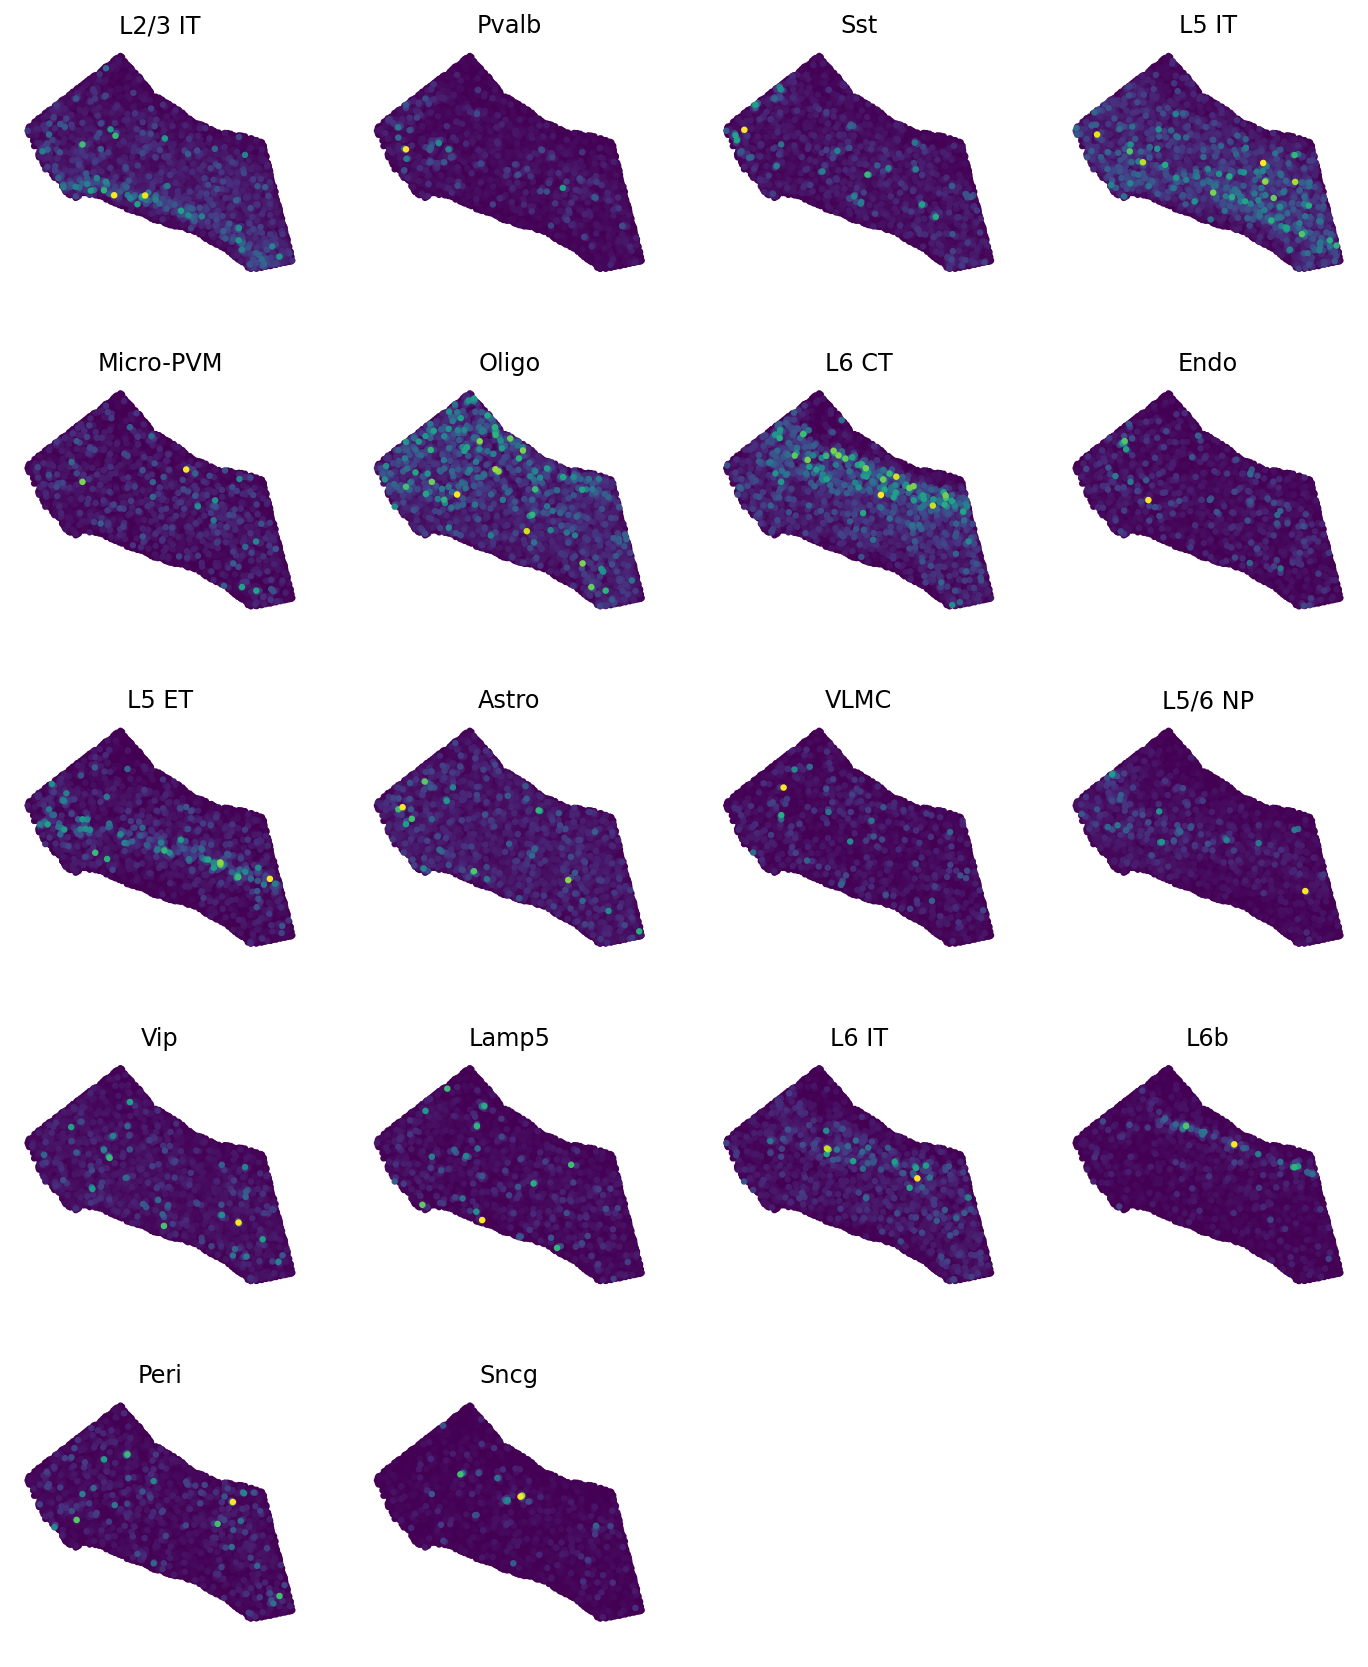

In [10]:
tg.plot_cell_annotation(ad_map, annotation='subclass_label', nrows=5, ncols=4)

- Let's try to get a sense of how mapping went. A good helper is `plot_training_scores` which gives us four panels:
    - The first panels is a histogram of the simlarity score for each training gene. Most genes are mapped with very high similarity (> .9) but few of them are just at ~.5. We would like to understand why for these genes the score is lower.
    - The second panel shows that there is a neat correlation between the training score of a gene (y-axis) and the sparsity of that gene in the snRNA-seq data (x-axis). Each dot is a training gene. The trend is that the sparser the gene the higher the score: this usually happens because very sparse gene are easier to map, as their pattern is matched by placing a few "jackpot cells" in the right spots.
    - The third panel is similar to the second one, but contains the gene sparsity of the spatial data. Spatial data are usually more sparse than single cell data, a discrepancy which is often responsible for low quality mapping.
    - Indeed, in the last panel, we show the training scores as a function of the difference in sparsity between the dataset. For genes with comparable sparsity, the mapped gene expression is very similar to that in the spatial data. However, if a gene is quite sparse in one dataset (typically, the spatial data) but not in other, the mapping score is lower. This occurs as Tangram cannot properly matched the gene pattern because of inconsistent amount of dropouts between the datasets.

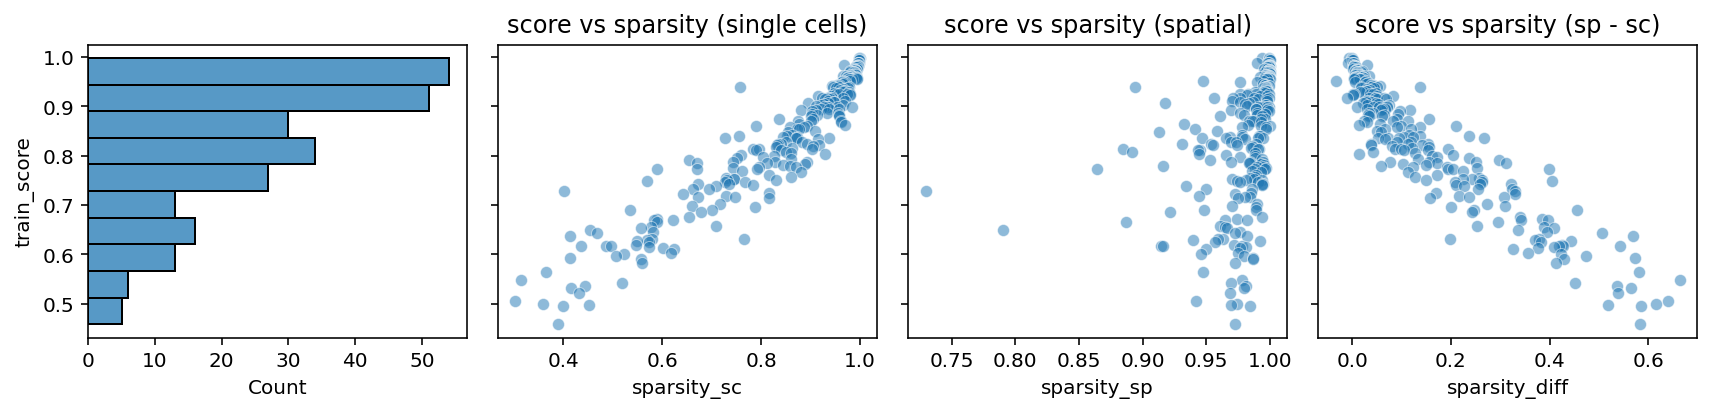

In [4]:
tg.plot_training_scores(ad_map, bins=50, alpha=.5)

In [3]:
df_celltypes = ml.project_cell_annotations(ad_map, annotation='subclass_label')
df_celltypes.head()

,L5/6 NP,Pvalb,Micro-PVM,L5 IT,Sst,Astro,L2/3 IT,Oligo,L6 CT,Sncg,Lamp5,Vip,Endo,L6 IT,Peri,L5 ET,L6b,VLMC
0,0.618031,0.643166,5.692631,8.727040,0.076059,7.435911,1.487424,14.062815,1.927541,0.289650,0.000182,0.000952,0.000734,0.632309,0.000612,0.000552,0.000178,2.001177
1,2.466946,3.626513,11.205803,15.257423,2.988977,7.703093,13.631992,13.837777,6.353005,0.628901,2.377511,0.345112,2.827740,1.316448,2.058672,5.195047,1.238069,2.988276
2,0.998839,8.740320,2.533499,10.120195,0.186661,0.272064,1.100509,1.772514,5.353720,0.000185,1.172372,0.254423,0.738555,0.001211,0.381247,4.887962,0.000321,0.000215
3,0.000245,16.746644,2.108286,2.101986,0.640566,13.729706,0.005001,11.659179,0.475520,0.000143,0.000733,0.207595,0.574655,0.000539,0.138314,0.000855,0.059259,0.684034
4,0.000390,0.003655,2.761151,6.611165,0.001166,0.828465,1.828906,5.634473,5.793218,0.000189,0.000321,0.177063,1.226236,3.840021,0.011226,0.001217,1.395598,0.151816


- These annotations can then be processed or, plotted "by hand".
- We can also use the helper below to project the annotation and visualize the probability maps in space.

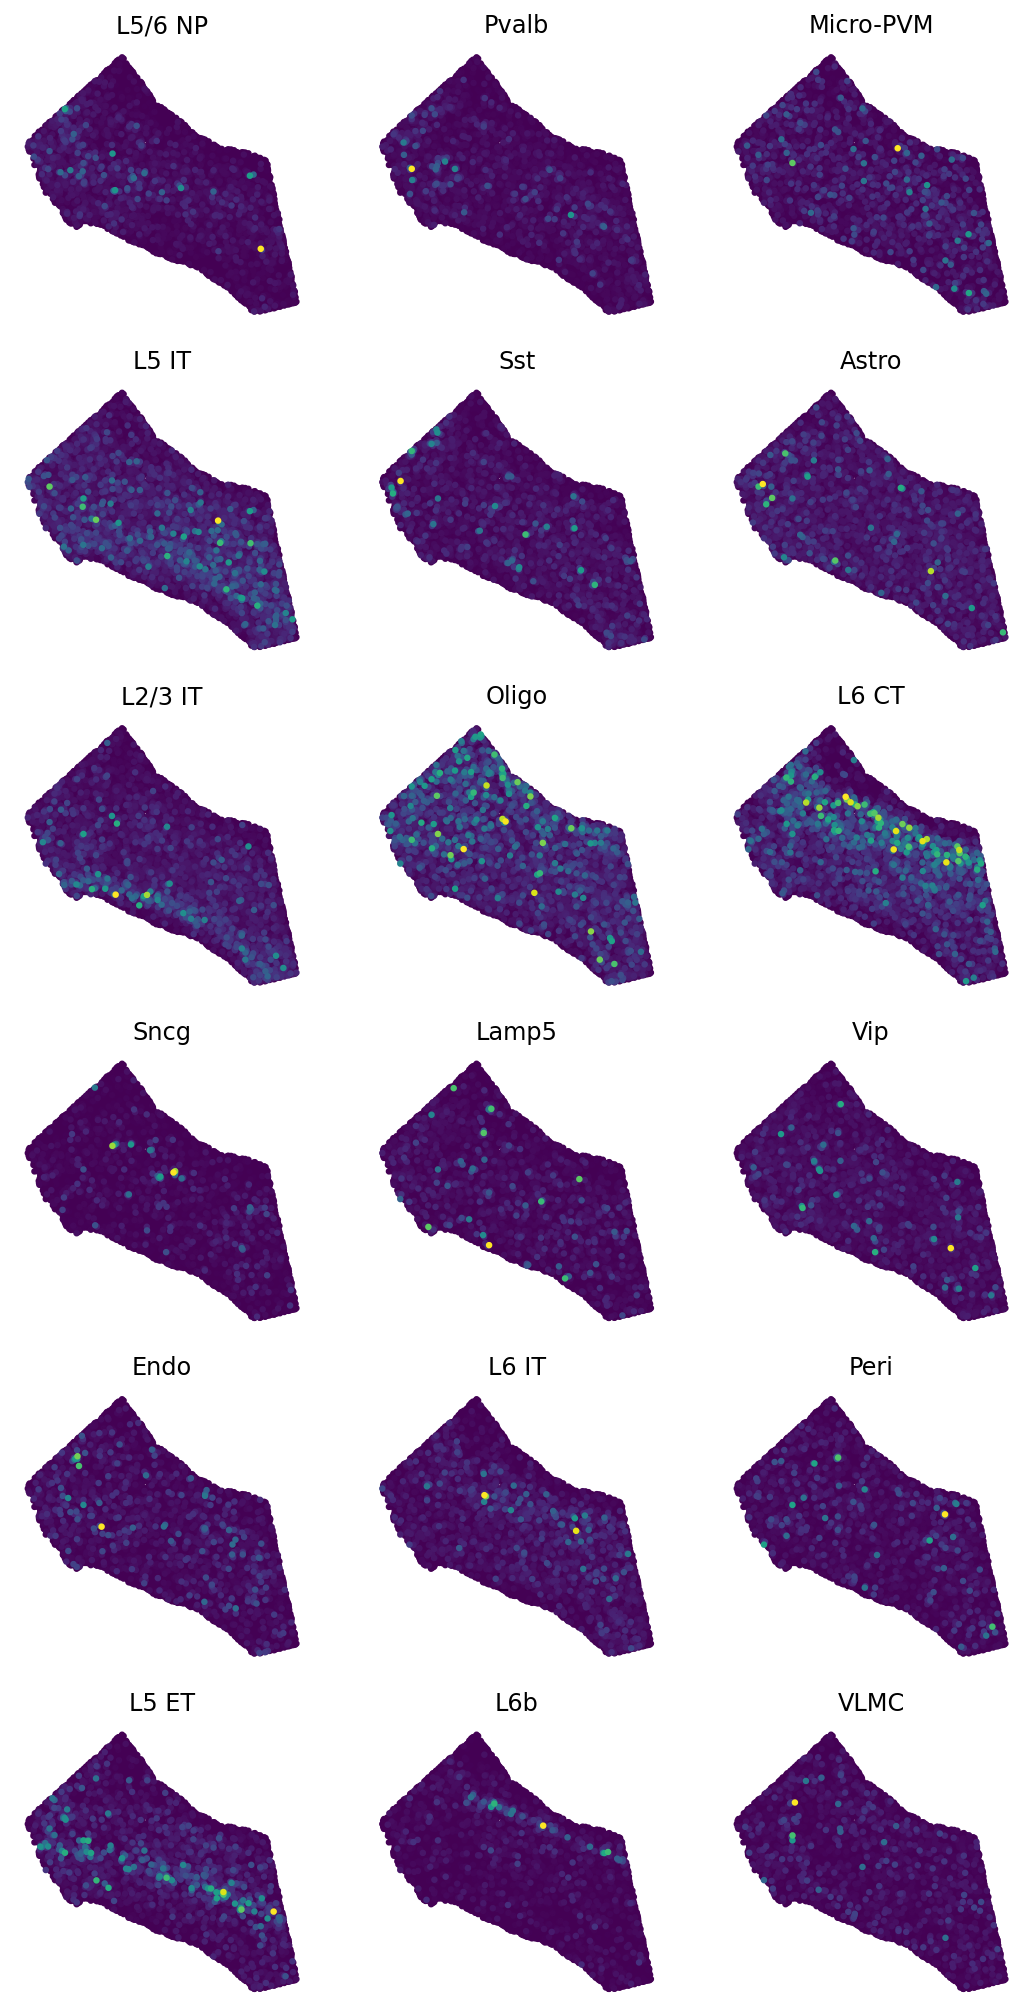

In [6]:
ml.plot_cell_annotation(ad_map, annotation='subclass_label', ncols=3, nrows=6)